## Imports

In [1]:
import operator
import numpy as np
import pickle as pkl
import random
from numpy import linalg as LA
from matplotlib import pyplot as plt
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from time import time
from multiprocessing import Pool
from scipy.stats import binned_statistic
from scipy.stats import pearsonr

import sys
import copy
import numpy as np
import pandas as pd
import os
import xarray as xr
from operator import itemgetter

from matplotlib import pyplot as plt
import matplotlib as mpl

## Define helper methods

In [8]:
# centralize buckets around test point to avoid bad results caused by test point near bucket edges
def centralize_buckets_around_test_point(bucket_size, base_bucket_edges, verbose, test_point_label):
    bucket_of_sample = np.digitize(test_point_label, base_bucket_edges).item()

    left_edge, right_edge = base_bucket_edges[bucket_of_sample-1], base_bucket_edges[bucket_of_sample]
    
    distance_left_edge, distance_right_edge = np.abs(left_edge - test_point_label), np.abs(right_edge - test_point_label)

    if distance_left_edge == distance_right_edge:
        return base_bucket_edges
    elif distance_left_edge > distance_right_edge:
        # point is closer on right side, shift bucked edges shift right
        distance_to_shift = bucket_size/2 - distance_right_edge
        bucket_edges_shifted = base_bucket_edges + distance_to_shift
    else:
        # point is closer on left side, shift bucked edges shift left
        distance_to_shift = bucket_size/2 - distance_left_edge
        bucket_edges_shifted = base_bucket_edges - distance_to_shift
        
    left_edge_shifted, right_edge_shifted = bucket_edges_shifted[bucket_of_sample-1], bucket_edges_shifted[bucket_of_sample]
    
    distance_left_edge_shifted, distance_right_edge_shifted = left_edge_shifted - test_point_label, right_edge_shifted - test_point_label
    
    difference_between_left_right_shifted_distance = np.round(np.float(np.abs(distance_left_edge_shifted) - np.abs(distance_right_edge_shifted)), 3)
    if difference_between_left_right_shifted_distance != 0:
        raise Exception('Distance was not equal after shift! [%s]' % difference_between_left_right_shifted_distance)

    if verbose:
        print("Bucket of samples:", bucket_of_sample)
        print("Label:", test_point_label)
        print("Edges:", left_edge, right_edge)
        print("Distance edges:", distance_left_edge, distance_right_edge)
        print("Distance to shift", distance_to_shift)
        print("Shifted edges:", left_edge_shifted, right_edge_shifted)
        print("Distance to shifted edges:", distance_left_edge_shifted, distance_right_edge_shifted)
        print("Difference between left & right side: %.3f" % difference_between_left_right_shifted_distance)
        print()
        
    return bucket_edges_shifted

# dictionary of month index to string
month_dict={0:'Jan', 1:'Feb', 2:'Mar', 3:'Apr', 4:'May', 5:'Jun', 6:'Jul', 7:'Aug', 8:'Sept', 9:'Okt', 10:'Nov', 11:'Dec'}

# index of station id to idx in array representation
station_idx_mapping = {}
for s_idx, s in enumerate(stations.data):
    station_idx_mapping[s] = s_idx

# inverse data normalization for human understandable representations of height
height_diff_min = -520.1044921875
height_diff_max = 382.5205078125
def inverseHeightDiffNormalization(x):
    x=np.array(x)
    x = x*(height_diff_max-height_diff_min)
    return x

# plot shapley sum per characteristic, i.e. temperature label, hour of prediction, month of prediction,
# station height and grid point-station height difference
def plotBestWorstShapleyResultsAllData(k_largest, influences):
    
    # define number of influences to be plotted
    k_largest_influences = k_largest
    k_smallest_influences = k_largest

    # get largest and smallest influences
    largest_influence_idx = np.argsort(influences)[-k_largest_influences:]
    smallest_influence_idx = np.argsort(influences)[:k_smallest_influences]
    
    # get array of ('Station','Init') ordered by training sample indices
    init_station_train_data = train_data_set.loc[:,'Init':'Station'].as_matrix()
    
    # get station & init samples with the largest influence
    station_init_by_largest_influence = []
    for train_sample_idx in largest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        temperature_label = train_label_set[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data.item()
        station_init_by_largest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, inverseHeightDiffNormalization(station_hh_diff),temperature_label)]
    station_init_by_largest_influence = sorted(station_init_by_largest_influence, key=itemgetter(2))
    largest_influence_data = np.array(list(zip(*station_init_by_largest_influence)), dtype='float64')

    # get station & init samples with the smallest influence
    station_init_by_smallest_influence = []
    for train_sample_idx in smallest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        temperature_label = train_label_set[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data.item()
        station_init_by_smallest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, inverseHeightDiffNormalization(station_hh_diff),temperature_label)]
    station_init_by_smallest_influence = sorted(station_init_by_smallest_influence, key=itemgetter(2))
    smallest_influence_data = np.array(list(zip(*station_init_by_smallest_influence)), dtype='float64')
    
    # plot influence against temperature label
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(14,6))
    
    # sum influence of most influential points per height
    min_temp_absolute = np.absolute(np.minimum(np.min(largest_influence_data[7].astype(int)), np.min(smallest_influence_data[7].astype(int)))-1)
    sum_largest_influences_per_temperature = np.bincount(largest_influence_data[7].astype(int) + min_temp_absolute, largest_influence_data[2])
    sum_smallest_influences_per_temperature = np.bincount(smallest_influence_data[7].astype(int) + min_temp_absolute, smallest_influence_data[2])
    
    max_absolute_influence = np.maximum(np.max(np.absolute(sum_largest_influences_per_temperature)),
                                        np.max(np.absolute(sum_smallest_influences_per_temperature))) * 1.1
    
    # plot stations with largest effect
    axes[0].bar(range(len(sum_largest_influences_per_temperature)) - min_temp_absolute, sum_largest_influences_per_temperature, color='blue', width=15)
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_ylabel('Sum of Shapley Values')
    axes[0].set_title('Largest %s' % k_largest_influences)
    
    # plot stations with smallest effect
    axes[1].bar(range(len(sum_smallest_influences_per_temperature)) - min_temp_absolute, sum_smallest_influences_per_temperature, color='red', width=15)
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s' % k_smallest_influences)
    axes[1].set_ylabel('Sum of Shapley Values')
    axes[1].set_xlabel('Temperature Label [°C]')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.suptitle('Shapley Values per Temperature Label (Error Prediction)', fontsize=18)
    plt.show()
    plt.close()
    
    
    # plot influence against height
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(14,6))
    
    # sum influence of most influential points per height
    sum_largest_influences_per_height = np.bincount(largest_influence_data[5].astype(int), largest_influence_data[2])
    sum_smallest_influences_per_height = np.bincount(smallest_influence_data[5].astype(int), smallest_influence_data[2])
    
    max_absolute_influence = np.maximum(np.max(np.absolute(sum_largest_influences_per_height)),
                                        np.max(np.absolute(sum_smallest_influences_per_height))) * 1.1
    
    # plot stations with largest effect
    axes[0].bar(range(len(sum_largest_influences_per_height)), sum_largest_influences_per_height, color='blue', width=15)
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_ylabel('Sum of Shapley Values')
    axes[0].set_title('Largest %s' % k_largest_influences)
    
    # plot stations with smallest effect
    axes[1].bar(range(len(sum_smallest_influences_per_height)), sum_smallest_influences_per_height, color='red', width=15)
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s' % k_smallest_influences)
    axes[1].set_ylabel('Sum of Shapley Values')
    axes[1].set_xlabel('Height [m]')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.suptitle('Shapley Values per Height (Error Prediction)', fontsize=18)
    plt.show()
    plt.close()
    
    # plot influence against height difference
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(14,6))
    
    # aggregate influence of most influential points per height difference
    largest_influences_per_height_difference = np.bincount(largest_influence_data[6].astype(int), largest_influence_data[2])
    smallest_influences_per_height_difference = np.bincount(smallest_influence_data[6].astype(int), smallest_influence_data[2])
    
    max_absolute_influence = np.maximum(np.max(np.absolute(largest_influences_per_height_difference)),
                                        np.max(np.absolute(smallest_influences_per_height_difference))) * 1.1
    
    # plot stations with largest effect
    axes[0].bar(range(len(largest_influences_per_height_difference)), largest_influences_per_height_difference, color='blue')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_ylabel('Sum of Shapley Values')
    axes[0].set_title('Largest %s' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].bar(range(len(smallest_influences_per_height_difference)), smallest_influences_per_height_difference, color='red')
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s' % k_smallest_influences)
    axes[1].set_ylabel('Sum of Shapley Values')
    axes[1].set_xlabel('Height Difference [m]')
    x_ticks_height_difference = np.linspace(0, height_diff_max + np.absolute(height_diff_min),15)
    x_ticklabels_height_difference = np.linspace(height_diff_min, height_diff_max,15)
    plt.setp(axes, xticks=x_ticks_height_difference, xticklabels=["%im" % hh for hh in x_ticklabels_height_difference])
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle('Shapley Values per Height Difference (Error Prediction)', fontsize=18)
    plt.show()
    plt.close()
    
    # plot influence by hour
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(14,6))
    
    # aggregate influence of most influential points per hour
    largest_influences_per_hour = np.bincount([(int(str(m)[6:8]) + 1) % 24 for m in largest_influence_data[1]],
                                                  largest_influence_data[2], 24)
    smallest_influences_per_hour = np.bincount([(int(str(m)[6:8]) + 1) % 24 for m in smallest_influence_data[1]],
                                                    smallest_influence_data[2], 24)
    
    max_absolute_influence = np.maximum(np.max(np.absolute(largest_influences_per_hour)),
                                        np.max(np.absolute(smallest_influences_per_hour))) * 1.1
    
    # plot stations with largest effect
    axes[0].bar(np.arange(0,24), largest_influences_per_hour, color='blue')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_ylabel('Sum of Shapley Values')
    axes[0].set_title('Largest %s' % k_largest_influences)
    
    # plot stations with largest effect
    axes[1].bar(np.arange(0,24), smallest_influences_per_hour, color='red')
    axes[1].set_xlim(-1,24,1)
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s' % k_smallest_influences)
    axes[1].set_ylabel('Sum of Shapley Values')
    axes[1].set_xlabel('Hour of Prediction')
    plt.suptitle('Shapley Values per Hour (Error Prediction)', fontsize=18)
    plt.setp(axes, xticks=range(24), xticklabels=["%02d:00" % h for h in range(24)])
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.close()

    # plot influence by month
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(14,6))
    
    # aggregate influence of most influential points per month
    print(set([int(str(m)[2:4]) for m in largest_influence_data[1]]))
    largest_influences_per_month = np.bincount([int(str(m)[2:4]) for m in largest_influence_data[1]],
                                                  largest_influence_data[2], 13)[1:]
    smallest_influences_per_month = np.bincount([int(str(m)[2:4]) for m in smallest_influence_data[1]],
                                                    smallest_influence_data[2], 13)[1:]
    
    max_absolute_influence = np.maximum(np.max(np.absolute(largest_influences_per_month)),
                                        np.max(np.absolute(smallest_influences_per_month))) * 1.1
    print(largest_influences_per_month) 
    # plot stations with largest effect
    axes[0].bar(np.arange(0,12), largest_influences_per_month, color='blue')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_ylabel('Sum of Shapley Values')
    axes[0].set_title('Largest %s' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].bar(np.arange(0,12), smallest_influences_per_month, color='red')
    axes[1].set_xlim(-1,12,1)
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s' % k_smallest_influences)
    axes[1].set_ylabel('Sum of Shapley Values')
    axes[1].set_xlabel('Month of Prediction')
    plt.suptitle('Shapley Values per Month (Error Prediction)', fontsize=18)
    plt.setp(axes[1], xticks=np.arange(0,12), xticklabels=[month_dict[m] for m in range(12)])
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.close()

## Load data

In [3]:
# load neural embeddings for directly predicting the 2m-temperature and for predicting the COSMO-1 error
with open('/home/ninow/master_thesis/code/project/results/data_valuation/neural_embeddings.pkl','rb') as handle:
    neural_embeddings = pkl.load(handle)
with open('/home/ninow/master_thesis/code/project/results/data_valuation/neural_embeddings_error_prediction.pkl','rb') as handle:
    neural_embeddings_error_prediction = pkl.load(handle)

In [4]:
# load station positions to plot them on map
station_data = pkl.load(open('/mnt/ds3lab-scratch/ninow/preprocessed_data/station/grid_size_1/time_invariant_data_per_station.pkl','rb'))
station_positions = station_data.station_position.sel(positinal_attribute = ['rlat', 'rlon','height_raw'])
stations = station_data.station
station_names = station_data.station_name
# load time invariant grid topo feature data
topo = pkl.load(open('/mnt/ds3lab-scratch/ninow/preprocessed_data/station/grid_size_1/time_invariant_data_per_station.pkl','rb'))
station_heigh_diff = topo.grid_data.sel(feature='HH_DIFF').squeeze()
stations_lat_idx = station_data.closest_grid_point.sel(direction = 'lat_2d_global')
stations_lat_idx = stations_lat_idx - np.min(stations_lat_idx)
stations_lon_idx = station_data.closest_grid_point.sel(direction = 'lon_2d_global')
stations_lon_idx = stations_lon_idx - np.min(stations_lon_idx)

In [5]:
# load prediction error from prediction run
prediction_error = pkl.load(open('/mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/knn_1/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/model_run_error.pkl', 'rb')).run_0

In [6]:
# load prediction error from prediction run for error label
prediction_error_error_label = pkl.load(open('/home/ninow/master_thesis/code/project/results/runs/error_label/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24//model_run_error.pkl', 'rb')).run_0

In [7]:
# load data statistic for highest and lowest height difference
data_statistic = pkl.load(open('/mnt/ds3lab-scratch/ninow/preprocessed_data/feature_summary_grid_1.pkl', 'rb'))

## Prepare Data

In [10]:
# split data set into train and test
train_data_set = neural_embeddings['train_embeddings']
train_label_set = neural_embeddings['train_labels']
test_data_set = neural_embeddings['test_embeddings']
test_label_set = neural_embeddings['test_labels']

# get numpy representation of neural embeddings
X_train = train_data_set.as_matrix()[:,2:]
Y_train_temp = train_label_set.as_matrix()[:]
X_test = test_data_set.as_matrix()[:,2:]
Y_test_temp = test_label_set.as_matrix()[:]

# calculate number of training examples
num_train_examples = X_train.shape[0]
num_test_examples = X_test.shape[0]
num_features = X_train.shape[1]

In [11]:
num_test_examples

103210

## Calculate Shapley Values with KNN-Regression

In [12]:
# calculate Eucleadian distance between vectors
# !!! This method was not developed by ourself, but received by the authors of the unpublished work about data valuation)
def get_distance(features, vector):
    norms = features.shape[0] * [0]
    for i in range(0, features.shape[0]):
        n = LA.norm(features[i] - vector)
        assert(n is not None)
        norms[i] = n
    return norms

# get shpley values for all training points on given test points
# !!! This method was not developed by ourself, but received by the authors of the unpublished work about data valuation)
def get_values(distances, test_idx, Y_train_shifted, Y_test_shifted):
    values = np.zeros(num_train_examples)
    i = len(distances)
    lastvalue = 0
    lastkey = -1
    K = 50
    for key in np.argsort(distances)[::-1]:
        if i == len(distances):
            lastvalue = 0
        else:
            # print(Y_train[key] == Y_test[test_idx], Y_train[lastkey] == Y_test[test_idx], Y_train[key], Y_test[test_idx], Y_train[lastkey], Y_test[test_idx])
            value = 1.0 * (1.0 * (Y_train_shifted[key] == Y_test_shifted[test_idx]) - 1.0 * (Y_train_shifted[lastkey] == Y_test_shifted[test_idx])) \
                                            / K * (min(K-1, i-1) + 1) / i
            lastvalue = lastvalue + value
        lastkey = key
        i = i - 1

        values[key] = lastvalue
    return values

# run knn calculation of shapley values
# !!! This method was not developed by ourself, but received by the authors of the unpublished work
# about data valuation. However, we adapted parts, especially the centralization of the test labels. !!!
def run_knn(test_indices, Y_train, Y_test, cetralize_function):
    n_test_samples = len(test_indices)
    for idx, i in enumerate(test_indices):
        start = time()
        
        # adapt the bins to be centralized around thest point
        bucket_edges_shifted = cetralize_function(Y_test[i])
    
        # get index of bucket for each training data
        Y_train_shifted = np.digitize(Y_train, bucket_edges_shifted) - 1
        Y_test_shifted = np.digitize(Y_test, bucket_edges_shifted) - 1
        
        distances = get_distance(X_train, X_test[i]) # get distance to test image
        knn_value = get_values(distances, i, Y_train_shifted, Y_test_shifted)
        
        try:
            knn_values += knn_value
        except:
            knn_values = knn_value
        
        if (i+1) % 50 == 0:
            print('Calculation of knn values for test idx=%s took %s [%.2f%%]' % (i, time() - start, (idx/len(test_indices))*100))
    return knn_values

# run experiment of shapley value calculation using knn approach
def get_knn_shapley_values(Y_train, Y_test, test_indices, bucket_size):
    # adapt the labels to classes
    min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
    n_classes = int(np.ceil((max_label - min_label)/bucket_size))

    # the size of each bucket
    size_of_bucket = (max_label - min_label)/n_classes

    # we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
    bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

    # initialize function for bucket centralization around test point
    cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

    # return results
    return (test_indices, run_knn(test_indices, Y_train, Y_test, cetralize_function))

## Calculate Shapley Values with KNN with Temp. prediction data

### Select randomly 20% of test data

In [13]:
knn_shapley_values = np.load('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_final/knn_results_20_percent_bucket_0_5_k_50.npz')['arr_0']
test_point_selection = []
for result in knn_shapley_values:
    test_point_selection += result[0]

In [14]:
# split test points into chunks to calculate the Shapley values in parallel
parallel_chunks = np.array_split(test_point_selection,16)

### Calculate shapley values in parallel using KNN approach

In [15]:
# parallel calculation of Shapley values using knn approach
start_time = time()
shapley_results = []
with Pool(processes=16) as pool:
    process_results = []
    # start process to calculate Shapley values in parallel on test point chunk
    for chunk_idx, chunk in enumerate(parallel_chunks):
        process_results.append(pool.apply_async(get_knn_shapley_values, (Y_train_temp, Y_test_temp, list(chunk), 0.5)))
        
    # add results from all processes to result list
    for ps_idx, ps_result in enumerate(process_results):
        # sync processes
        x = ps_result.get()
        shapley_results += [x]
        print('[Process %s] Synchronized after calculating shapley values.' % ps_idx)
        
n_test_points = len(test_point_selection)
runtime = time() - start_time
print("Calculation for %s test points took %ss:" % ())

Calculation of knn values for test idx=12799 took 36.1047637462616 [0.00%]
Calculation of knn values for test idx=37999 took 36.66302943229675 [0.08%]
Calculation of knn values for test idx=70699 took 36.039947509765625 [0.39%]
Calculation of knn values for test idx=38049 took 35.7183096408844 [0.70%]
Calculation of knn values for test idx=99 took 36.78001117706299 [1.08%]
Calculation of knn values for test idx=90099 took 36.766966819763184 [1.40%]
Calculation of knn values for test idx=64349 took 33.788785219192505 [1.71%]
Calculation of knn values for test idx=57649 took 33.86375403404236 [1.94%]
Calculation of knn values for test idx=149 took 36.469305992126465 [2.01%]
Calculation of knn values for test idx=50999 took 36.53769111633301 [2.17%]
Calculation of knn values for test idx=70799 took 36.523900270462036 [2.25%]
Calculation of knn values for test idx=25499 took 33.96589684486389 [2.40%]
Calculation of knn values for test idx=96849 took 34.065335273742676 [2.40%]
Calculation o

Calculation of knn values for test idx=65799 took 33.560816049575806 [24.73%]
Calculation of knn values for test idx=91649 took 33.725300788879395 [25.58%]
Calculation of knn values for test idx=1699 took 35.57288861274719 [25.56%]
Calculation of knn values for test idx=72299 took 35.537617206573486 [25.35%]
Calculation of knn values for test idx=39699 took 35.111709117889404 [26.67%]
Calculation of knn values for test idx=52599 took 34.418134689331055 [26.98%]
Calculation of knn values for test idx=78849 took 34.46573829650879 [26.82%]
Calculation of knn values for test idx=8149 took 33.931395530700684 [27.11%]
Calculation of knn values for test idx=39749 took 35.806050062179565 [27.52%]
Calculation of knn values for test idx=27149 took 34.35016107559204 [27.44%]
Calculation of knn values for test idx=20999 took 34.775503158569336 [27.29%]
Calculation of knn values for test idx=27199 took 35.16666507720947 [27.83%]
Calculation of knn values for test idx=85349 took 36.48575401306152 [2

Calculation of knn values for test idx=47299 took 36.52812337875366 [46.28%]
Calculation of knn values for test idx=67299 took 34.519259452819824 [46.90%]
Calculation of knn values for test idx=2949 took 35.76011109352112 [46.55%]
Calculation of knn values for test idx=86449 took 36.49997329711914 [46.90%]
Calculation of knn values for test idx=41099 took 35.01307392120361 [47.98%]
Calculation of knn values for test idx=3049 took 35.489825963974 [47.79%]
Calculation of knn values for test idx=67399 took 34.568976163864136 [48.53%]
Calculation of knn values for test idx=41149 took 34.700151681900024 [48.91%]
Calculation of knn values for test idx=15949 took 35.87532687187195 [49.53%]
Calculation of knn values for test idx=86649 took 33.88657593727112 [49.77%]
Calculation of knn values for test idx=22399 took 34.04571270942688 [49.84%]
Calculation of knn values for test idx=41249 took 34.037291526794434 [50.85%]
Calculation of knn values for test idx=47499 took 35.967849016189575 [49.92%

Calculation of knn values for test idx=10899 took 34.20344424247742 [70.57%]
Calculation of knn values for test idx=81749 took 33.893516302108765 [71.94%]
Calculation of knn values for test idx=17299 took 36.07114338874817 [71.24%]
Calculation of knn values for test idx=94649 took 33.75099992752075 [72.17%]
Calculation of knn values for test idx=101399 took 33.75476408004761 [72.09%]
Calculation of knn values for test idx=23699 took 35.0772819519043 [71.86%]
Calculation of knn values for test idx=10999 took 34.91669154167175 [72.50%]
Calculation of knn values for test idx=75499 took 34.49711847305298 [72.56%]
Calculation of knn values for test idx=49049 took 34.02899670600891 [72.79%]
Calculation of knn values for test idx=101499 took 35.517011642456055 [73.10%]
Calculation of knn values for test idx=4699 took 37.03179955482483 [72.42%]
Calculation of knn values for test idx=55749 took 37.02910780906677 [73.18%]
Calculation of knn values for test idx=42749 took 36.30045413970947 [73.72

[Process 0] Synchronized after calculating shapley values.
[Process 1] Synchronized after calculating shapley values.
[Process 2] Synchronized after calculating shapley values.
[Process 3] Synchronized after calculating shapley values.
[Process 4] Synchronized after calculating shapley values.
[Process 5] Synchronized after calculating shapley values.
[Process 6] Synchronized after calculating shapley values.
[Process 7] Synchronized after calculating shapley values.
[Process 8] Synchronized after calculating shapley values.
[Process 9] Synchronized after calculating shapley values.
[Process 10] Synchronized after calculating shapley values.
[Process 11] Synchronized after calculating shapley values.
[Process 12] Synchronized after calculating shapley values.
[Process 13] Synchronized after calculating shapley values.
[Process 14] Synchronized after calculating shapley values.
[Process 15] Synchronized after calculating shapley values.


TypeError: not enough arguments for format string

In [17]:
n_test_points, runtime

(20642, 45056.15948557854)

In [109]:
# save calculated Shapley values
np.savez('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_final/knn_results_20_percent_bucket_2_0_k_50', shapley_results)

In [17]:
# load existing Shapley values
shapley_results_temp_0_5 = np.load('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_final/knn_results_20_percent_bucket_0_5_k_50.npz')['arr_0']

## Results with Shapley values of temperature prediction with bucket size 0.5°C

In [8]:
shapley_results_temp_0_5 = np.load('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_final/knn_results_20_percent_bucket_0_5_k_50.npz')['arr_0']

In [21]:
# aggregate Shapley resutls
complete_shapley_sum_0_5 = None
for result in shapley_results_temp_0_5:
    try:
        complete_shapley_sum_0_5 += result[1]
    except:
        print('First')
        complete_shapley_sum_0_5 = result[1]

First


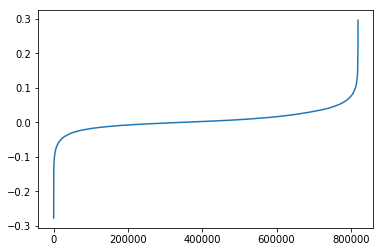

In [22]:
# plot ordered Shapley values
ordered_shapley_indices = np.argsort(complete_shapley_sum_0_5)
plt.plot(np.arange(len(ordered_shapley_indices)), complete_shapley_sum_0_5[ordered_shapley_indices])
plt.show()

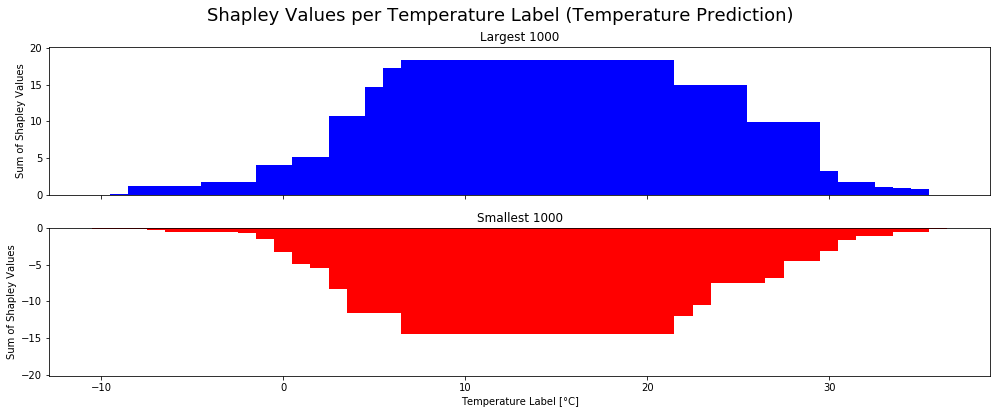

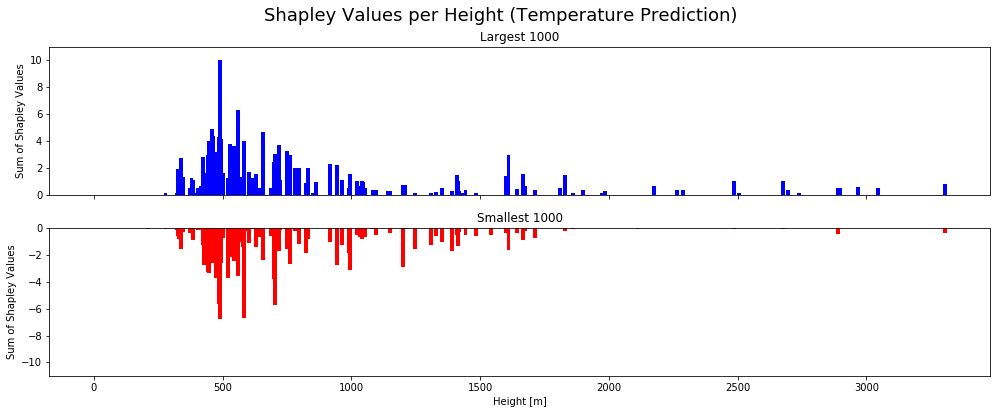

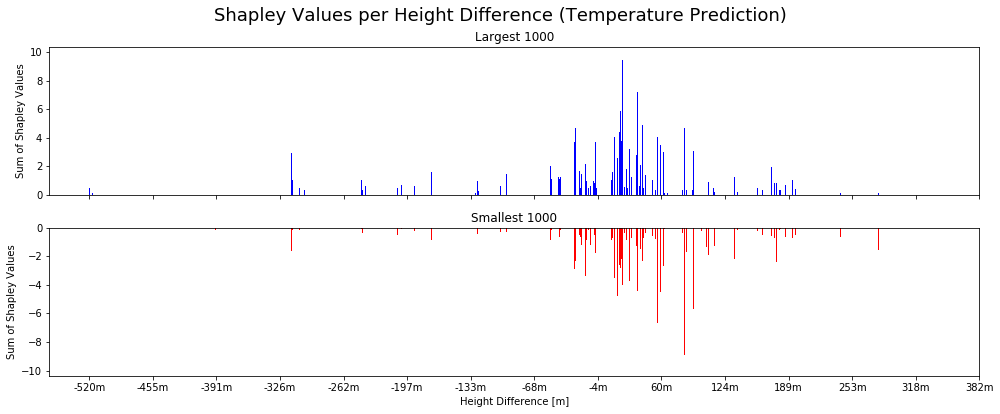

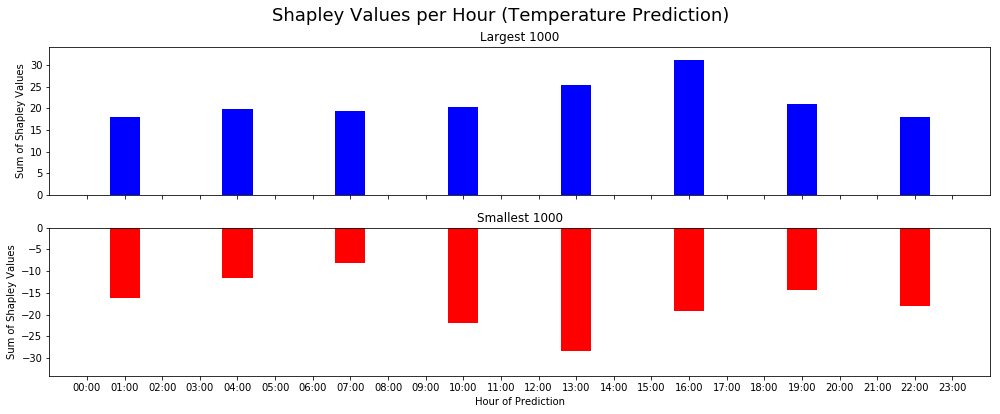

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
[ 0.3459354   0.82371684  4.91620217  9.82372224 25.13735994 51.49033311
 23.90212724 32.21239751 15.38650531  6.50600787  2.01011742  0.1648298 ]


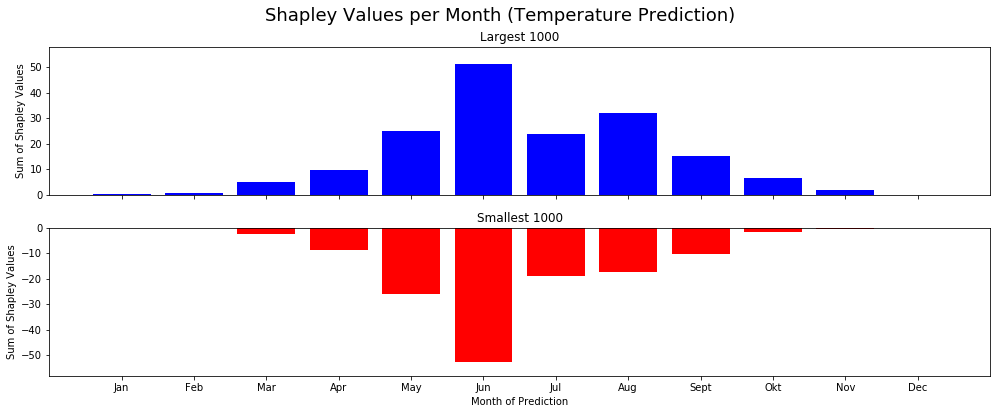

In [334]:
# plot aggregated results of best and worst training points for specific characteristics
plotBestWorstShapleyResultsAllData(1000, complete_shapley_sum_0_5)

### Plot shapley values against label

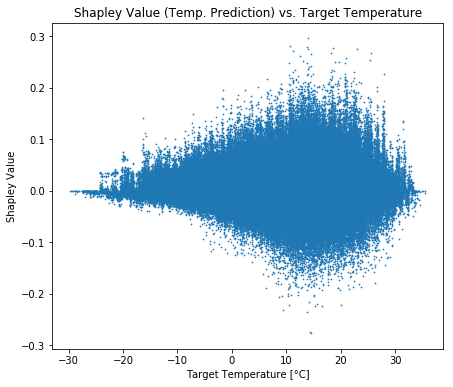

In [218]:
plt.figure(figsize=(7,6))
plt.scatter(Y_train_temp,complete_shapley_sum_0_5,s=0.5)
plt.xlabel('Target Temperature [°C]')
plt.ylabel('Shapley Value')
plt.title('Shapley Value (Temp. Prediction) vs. Target Temperature')
plt.show()

### Plot shapley values against model error

In [10]:
station_index_dict = {}
for s_idx, s in enumerate(prediction_error.station.data):
    station_index_dict[s] = s_idx

init_index_dict = {}
for i_idx, i in enumerate(prediction_error.init.data):
    init_index_dict[i] = i_idx

In [16]:
train_data_set_init_station = train_data_set[['Init', 'Station']]
model_error = prediction_error.sel(data = 'difference')
model_error_temperature_prediction = np.zeros(train_data_set_init_station.shape[0])
for idx in train_data_set_init_station.index:
    init, station = train_data_set_init_station.iloc[idx]
    model_error_temperature_prediction[idx] = model_error.isel(init = init_index_dict[init], station = station_index_dict[station])
    if (idx + 1) % 1000 == 0:
        print("Samples processed: %s" % idx)

Samples processed: 999
Samples processed: 1999
Samples processed: 2999
Samples processed: 3999
Samples processed: 4999
Samples processed: 5999
Samples processed: 6999
Samples processed: 7999
Samples processed: 8999
Samples processed: 9999
Samples processed: 10999
Samples processed: 11999
Samples processed: 12999
Samples processed: 13999
Samples processed: 14999
Samples processed: 15999
Samples processed: 16999
Samples processed: 17999
Samples processed: 18999
Samples processed: 19999
Samples processed: 20999
Samples processed: 21999
Samples processed: 22999
Samples processed: 23999
Samples processed: 24999
Samples processed: 25999
Samples processed: 26999
Samples processed: 27999
Samples processed: 28999
Samples processed: 29999
Samples processed: 30999
Samples processed: 31999
Samples processed: 32999
Samples processed: 33999
Samples processed: 34999
Samples processed: 35999
Samples processed: 36999
Samples processed: 37999
Samples processed: 38999
Samples processed: 39999
Samples pro

Samples processed: 320999
Samples processed: 321999
Samples processed: 322999
Samples processed: 323999
Samples processed: 324999
Samples processed: 325999
Samples processed: 326999
Samples processed: 327999
Samples processed: 328999
Samples processed: 329999
Samples processed: 330999
Samples processed: 331999
Samples processed: 332999
Samples processed: 333999
Samples processed: 334999
Samples processed: 335999
Samples processed: 336999
Samples processed: 337999
Samples processed: 338999
Samples processed: 339999
Samples processed: 340999
Samples processed: 341999
Samples processed: 342999
Samples processed: 343999
Samples processed: 344999
Samples processed: 345999
Samples processed: 346999
Samples processed: 347999
Samples processed: 348999
Samples processed: 349999
Samples processed: 350999
Samples processed: 351999
Samples processed: 352999
Samples processed: 353999
Samples processed: 354999
Samples processed: 355999
Samples processed: 356999
Samples processed: 357999
Samples proc

Samples processed: 636999
Samples processed: 637999
Samples processed: 638999
Samples processed: 639999
Samples processed: 640999
Samples processed: 641999
Samples processed: 642999
Samples processed: 643999
Samples processed: 644999
Samples processed: 645999
Samples processed: 646999
Samples processed: 647999
Samples processed: 648999
Samples processed: 649999
Samples processed: 650999
Samples processed: 651999
Samples processed: 652999
Samples processed: 653999
Samples processed: 654999
Samples processed: 655999
Samples processed: 656999
Samples processed: 657999
Samples processed: 658999
Samples processed: 659999
Samples processed: 660999
Samples processed: 661999
Samples processed: 662999
Samples processed: 663999
Samples processed: 664999
Samples processed: 665999
Samples processed: 666999
Samples processed: 667999
Samples processed: 668999
Samples processed: 669999
Samples processed: 670999
Samples processed: 671999
Samples processed: 672999
Samples processed: 673999
Samples proc

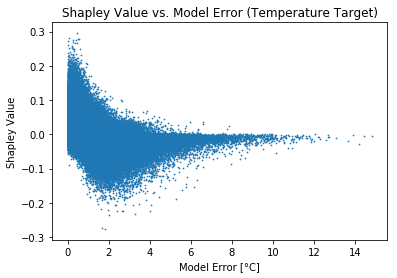

In [264]:
plt.scatter(np.abs(model_error_temperature_prediction), complete_shapley_sum_0_5, s=0.5)
plt.xlabel('Model Error [°C]')
plt.ylabel('Shapley Value')
plt.title('Shapley Value vs. Model Error (Temperature Target)')
plt.show()

### Plot distribution of model error for directly predicting 2m-temperature

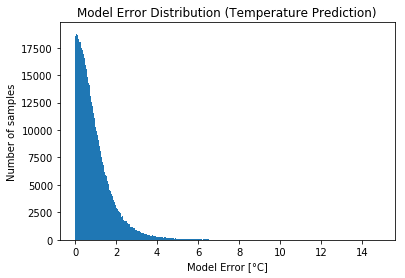

In [17]:
plt.hist(np.abs(model_error_temperature_prediction), bins=500)
plt.xlabel('Model Error [°C]')
plt.ylabel('Number of samples')
plt.title('Model Error Distribution (Temperature Prediction)')
plt.show()

### Plot baseline error agaist model error

In [151]:
model_error = prediction_error.sel(data = 'difference')
baseline_error = prediction_error.sel(data = 'cosmo') - prediction_error.sel(data = 'target')

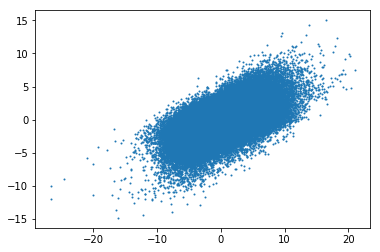

In [155]:
plt.scatter(baseline_error.data.flatten(), model_error.data.flatten(), s=1)
plt.show()

## Results with Shapley values of error prediction with 131 classes

In [28]:
shapley_results_error_classes_131 = np.load('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_final/knn_results_20_percent_class_131_k_50_error_prediction.npz')['arr_0']

In [29]:
# aggregate results
complete_shapley_sum_error_classes_131 = None
for result in shapley_results_error_classes_131:
    try:
        complete_shapley_sum_error_classes_131 += result[1]
    except:
        print('First')
        complete_shapley_sum_error_classes_131 = result[1]

First


In [64]:
complete_shapley_sum_error_classes_131

array([ 0.00580504,  0.01173742,  0.003723  , ...,  0.01716587,
        0.01174218, -0.00602207])

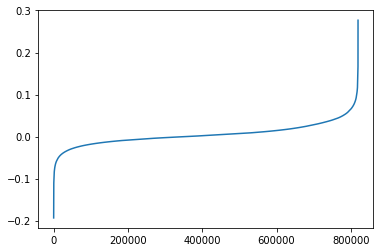

In [65]:
# Plot ordered Shapley values
ordered_shapley_indices_error_classes_131 = np.argsort(complete_shapley_sum_error_classes_131)
plt.plot(np.arange(len(ordered_shapley_indices_error_classes_131)), complete_shapley_sum_error_classes_131[ordered_shapley_indices_error_classes_131])
plt.show()

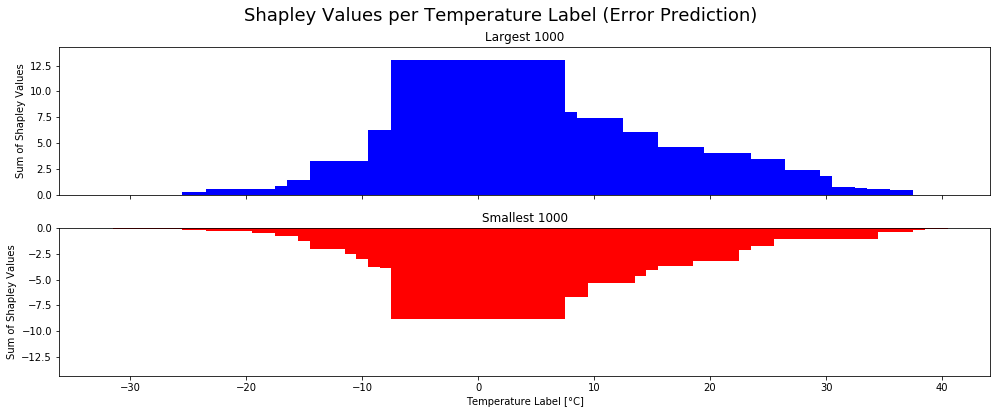

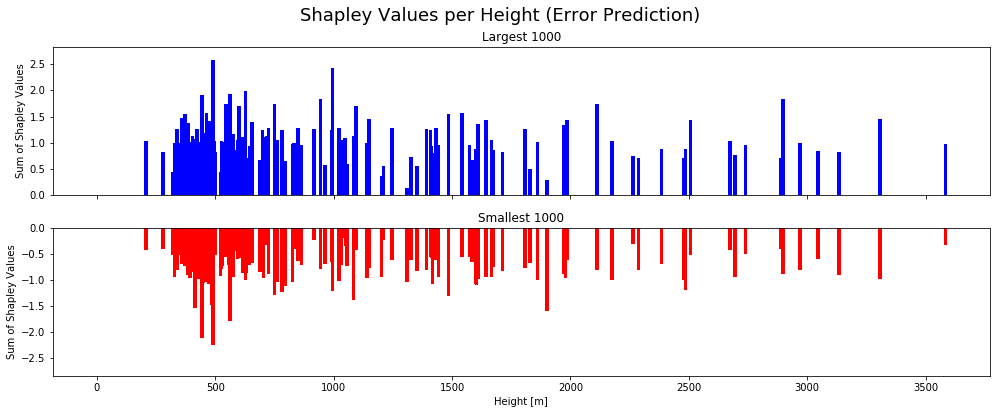

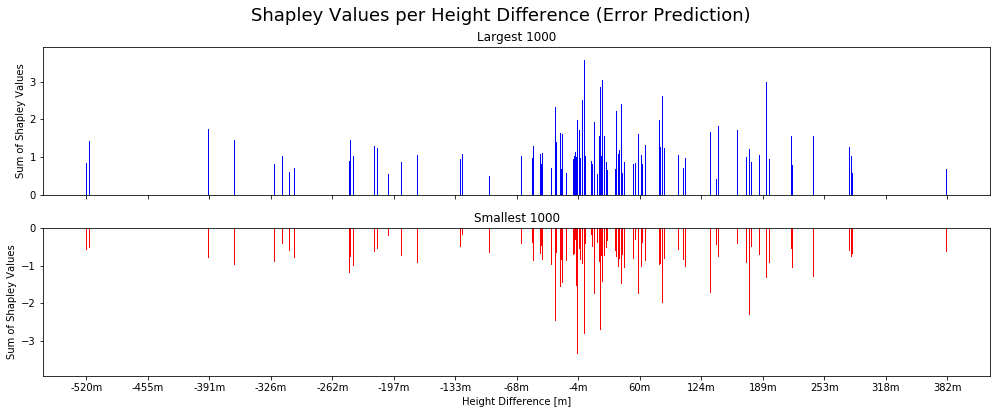

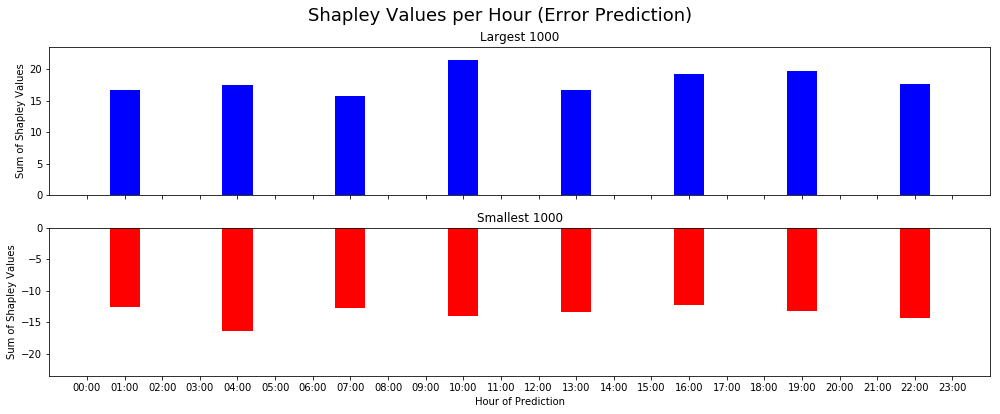

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
[15.69520924 16.43067757 11.86233924  8.0407987   6.05291684 12.1408482
  9.43586608  8.24825377  9.14838965 16.7998417  15.96127332 14.82598571]


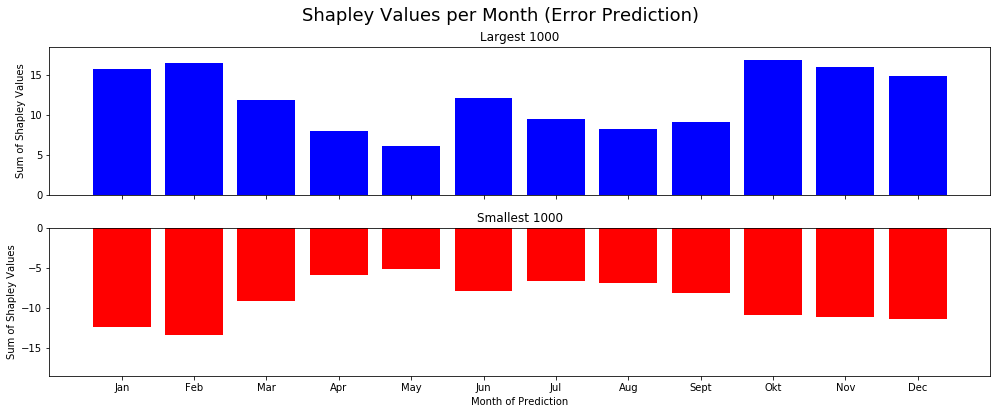

In [340]:
# plot aggregated results of best and worst training points for specific characteristics
plotBestWorstShapleyResultsAllData(1000, complete_shapley_sum_error_classes_131)

### Plot shapley values against model error on error labels

In [123]:
# calculate temperature prediction with the predicted COSMO-1 error
error_label_prediction = prediction_error_error_label.sel(data = 'cosmo') - prediction_error_error_label.sel(data = 'prediction')

In [124]:
# calculate model temperature prediction error for error prediction
error_label_prediction_error = error_label_prediction - prediction_error_error_label.sel(data = 'target_temperature')

In [27]:
station_index_dict = {}
for s_idx, s in enumerate(prediction_error_error_label.station.data):
    station_index_dict[s] = s_idx

init_index_dict = {}
for i_idx, i in enumerate(prediction_error_error_label.init.data):
    init_index_dict[i] = i_idx


train_data_set_init_station = neural_embeddings_error_prediction['train_embeddings'][['Init', 'Station']]
model_error = prediction_error_error_label.sel(data = 'difference')
target_error = prediction_error_error_label.sel(data = 'target')
target_temperature = prediction_error_error_label.sel(data = 'target_temperature')
model_error_error_label = np.zeros(train_data_set_init_station.shape[0])
target_error_label = np.zeros(train_data_set_init_station.shape[0])
target_error_label_temperature = np.zeros(train_data_set_init_station.shape[0])
for idx in train_data_set_init_station.index:
    init, station = train_data_set_init_station.iloc[idx]
    model_error_error_label[idx] = model_error.isel(init = init_index_dict[init], station = station_index_dict[station])
    target_error_label[idx] = target_error.isel(init = init_index_dict[init], station = station_index_dict[station])
    target_error_label_temperature[idx] = target_temperature.isel(init = init_index_dict[init], station = station_index_dict[station])
    if (idx + 1) % 1000 == 0:
        print("Samples processed: %s" % idx)

Samples processed: 999
Samples processed: 1999
Samples processed: 2999
Samples processed: 3999
Samples processed: 4999
Samples processed: 5999
Samples processed: 6999
Samples processed: 7999
Samples processed: 8999
Samples processed: 9999
Samples processed: 10999
Samples processed: 11999
Samples processed: 12999
Samples processed: 13999
Samples processed: 14999
Samples processed: 15999
Samples processed: 16999
Samples processed: 17999
Samples processed: 18999
Samples processed: 19999
Samples processed: 20999
Samples processed: 21999
Samples processed: 22999
Samples processed: 23999
Samples processed: 24999
Samples processed: 25999
Samples processed: 26999
Samples processed: 27999
Samples processed: 28999
Samples processed: 29999
Samples processed: 30999
Samples processed: 31999
Samples processed: 32999
Samples processed: 33999
Samples processed: 34999
Samples processed: 35999
Samples processed: 36999
Samples processed: 37999
Samples processed: 38999
Samples processed: 39999
Samples pro

Samples processed: 320999
Samples processed: 321999
Samples processed: 322999
Samples processed: 323999
Samples processed: 324999
Samples processed: 325999
Samples processed: 326999
Samples processed: 327999
Samples processed: 328999
Samples processed: 329999
Samples processed: 330999
Samples processed: 331999
Samples processed: 332999
Samples processed: 333999
Samples processed: 334999
Samples processed: 335999
Samples processed: 336999
Samples processed: 337999
Samples processed: 338999
Samples processed: 339999
Samples processed: 340999
Samples processed: 341999
Samples processed: 342999
Samples processed: 343999
Samples processed: 344999
Samples processed: 345999
Samples processed: 346999
Samples processed: 347999
Samples processed: 348999
Samples processed: 349999
Samples processed: 350999
Samples processed: 351999
Samples processed: 352999
Samples processed: 353999
Samples processed: 354999
Samples processed: 355999
Samples processed: 356999
Samples processed: 357999
Samples proc

Samples processed: 636999
Samples processed: 637999
Samples processed: 638999
Samples processed: 639999
Samples processed: 640999
Samples processed: 641999
Samples processed: 642999
Samples processed: 643999
Samples processed: 644999
Samples processed: 645999
Samples processed: 646999
Samples processed: 647999
Samples processed: 648999
Samples processed: 649999
Samples processed: 650999
Samples processed: 651999
Samples processed: 652999
Samples processed: 653999
Samples processed: 654999
Samples processed: 655999
Samples processed: 656999
Samples processed: 657999
Samples processed: 658999
Samples processed: 659999
Samples processed: 660999
Samples processed: 661999
Samples processed: 662999
Samples processed: 663999
Samples processed: 664999
Samples processed: 665999
Samples processed: 666999
Samples processed: 667999
Samples processed: 668999
Samples processed: 669999
Samples processed: 670999
Samples processed: 671999
Samples processed: 672999
Samples processed: 673999
Samples proc

### Plot Shapley values against model error

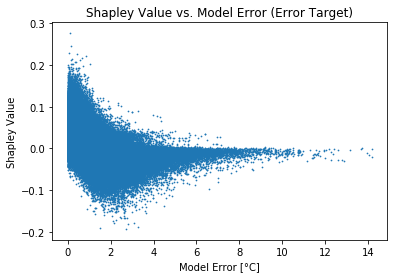

In [259]:
plt.scatter(np.abs(model_error_error_label), complete_shapley_sum_error_classes_131, s=0.5)
plt.xlabel('Model Error [°C]')
plt.ylabel('Shapley Value')
plt.title('Shapley Value vs. Model Error (Error Target)')
plt.show()

### Plot error distribution of predicting the model error

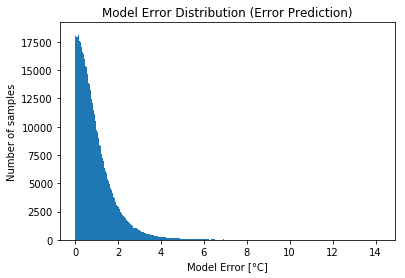

In [31]:
plt.hist(np.abs(model_error_error_label), bins=500)
plt.xlabel('Model Error [°C]')
plt.ylabel('Number of samples')
plt.title('Model Error Distribution (Error Prediction)')
plt.show()

### Plot shapley values against target temperature

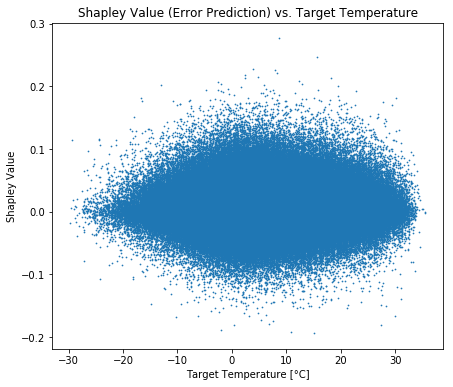

In [219]:
plt.figure(figsize=(7,6))
plt.scatter(neural_embeddings['train_labels'].as_matrix(),complete_shapley_sum_error_classes_131,s=0.5)
plt.xlabel('Target Temperature [°C]')
plt.ylabel('Shapley Value')
plt.title('Shapley Value (Error Prediction) vs. Target Temperature')
plt.show()

# Compare Prediction Error correleations

### Calculate different errors

In [176]:
cosmo_prediction = prediction_error.sel(data = 'cosmo')
temperature_prediction_label = prediction_error.sel(data = 'target')
teperature_prediction_model_prediction = prediction_error.sel(data = 'prediction')
cosmo_error = cosmo_prediction - temperature_prediction_label
teperature_prediction_model_error = prediction_error.sel(data = 'difference')

In [178]:
error_prediction_label = prediction_error_error_label.sel(data = 'target')
error_prediction_temperature_label = prediction_error_error_label.sel(data = 'target_temperature')
error_prediction_model_prediction = prediction_error_error_label.sel(data = 'prediction')
error_prediction_model_temperature_prediction = cosmo_prediction - error_prediction_model_prediction
error_prediction_model_error = prediction_error_error_label.sel(data = 'difference')
error_prediction_model_temperature_error = error_prediction_model_temperature_prediction - error_prediction_temperature_label

### Plot error correlation between predicting temperatue vs. predicting error

In [375]:
# split training and test points
train_inits = [t[0] for t in prediction_error.init_type_mapping if t[1] == 'train']
test_inits = [t[0] for t in prediction_error.init_type_mapping if t[1] == 'test']

In [378]:
temperature_prediction_train_error = prediction_error.sel(init = train_inits, data = 'difference').data.flatten()
temperature_prediction_test_error = prediction_error.sel(init = test_inits, data = 'difference').data.flatten()

In [379]:
error_prediction_train_error = prediction_error_error_label.sel(init = train_inits, data = 'difference').data.flatten()
error_prediction_test_error = prediction_error_error_label.sel(init = test_inits, data = 'difference').data.flatten()

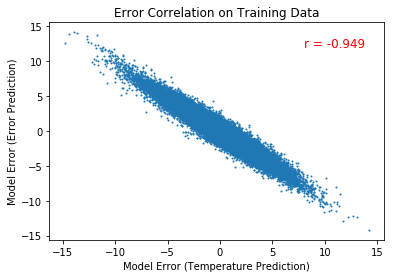

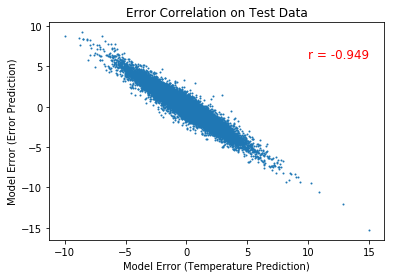

In [395]:
# filter data points with a "nan" as a label, denoting missing station measurements
train_nan_filter = ~np.isnan(temperature_prediction_train_error)
test_nan_filter = ~np.isnan(temperature_prediction_test_error)

pearson_r_training = pearsonr(temperature_prediction_train_error[train_nan_filter], error_prediction_train_error[train_nan_filter])[0]
pearson_r_test = pearsonr(temperature_prediction_test_error[test_nan_filter], error_prediction_test_error[test_nan_filter])[0]

plt.scatter(temperature_prediction_train_error, error_prediction_train_error, s=1)
plt.text(8,12,'r = %.3f' % pearson_r_training, color='red', fontsize=12)
plt.xlabel('Model Error (Temperature Prediction)')
plt.ylabel('Model Error (Error Prediction)')
plt.title('Error Correlation on Training Data')
plt.show()
plt.scatter(temperature_prediction_test_error, error_prediction_test_error, s=1)
plt.text(10,6,'r = %.3f' % pearson_r_test, color='red', fontsize=12)
plt.xlabel('Model Error (Temperature Prediction)')
plt.ylabel('Model Error (Error Prediction)')
plt.title('Error Correlation on Test Data')
plt.show()

## Run a KNN-Regression on Error Prediction

### Get COSMO-1 prediction and Temperature Label to calculate RMSE with Error Label

In [ ]:
trained_knn_regressors = {}
rmse_result_temp_prediction = []
for K in [1,3,5,10,20,50,100,200, 500, 1000, 2000]:
    # take start time
    start = time()
    
    # define, fit and predict KNN-regressor
    knn = neighbors.KNeighborsRegressor(K, weights='distance', n_jobs=16).fit(X_train, Y_train_temp)
    
    # store trained KNN-Regressor
    trained_knn_regressors[K] = knn
    
    y_ = knn.predict(X_test)
    
    # calc. RMSE
    rmse = np.sqrt(np.mean(np.square(y_ - Y_test_temp)))
    
    rmse_result_temp_prediction += [(K, rmse)]
    
    # print results
    print("%sNN-Regression took %ss with an RMSE = %2.5f" % (K, str(time()-start), rmse))

### KNN regression results error prediction

1NN-Regression took 50.12191104888916s with an RMSE = 1.72212<br>
3NN-Regression took 49.85099935531616s with an RMSE = 1.43375<br>
5NN-Regression took 44.14502501487732s with an RMSE = 1.37092<br>
10NN-Regression took 63.615517139434814s with an RMSE = 1.32108<br>
20NN-Regression took 87.02226376533508s with an RMSE = 1.29733<br>
50NN-Regression took 68.16496276855469s with an RMSE = 1.28431<br>
100NN-Regression took 82.94226670265198s with an RMSE = 1.28147<br>
200NN-Regression took 122.80988574028015s with an RMSE = 1.28154<br>
500NN-Regression took 131.22765946388245s with an RMSE = 1.28332<br>
1000NN-Regression took 202.61535668373108s with an RMSE = 1.28571<br>

In [209]:
np.savez('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/knn_regression_temperature_label', rmse_result_temp_prediction)

### Get COSMO-1 prediction and Temperature Label to calculate RMSE with Error Label

In [ ]:
# calculate indices for fast index lookup
station_index_dict = {}
for s_idx, s in enumerate(prediction_error_error_label.station.data):
    station_index_dict[s] = s_idx

init_index_dict = {}
for i_idx, i in enumerate(prediction_error_error_label.init.data):
    init_index_dict[i] = i_idx

test_data_set_init_station = neural_embeddings_error_prediction['test_embeddings'][['Init', 'Station']]
cosmo_prediction = prediction_error_error_label.sel(data = 'cosmo')
cosmo_test_prediction = np.zeros(test_data_set_init_station.shape[0])
temperature_label = prediction_error_error_label.sel(data = 'target_temperature')
temperature_test_label = np.zeros(test_data_set_init_station.shape[0])
for idx in test_data_set_init_station.index:
    init, station = test_data_set_init_station.iloc[idx]
    cosmo_test_prediction[idx] = cosmo_prediction.isel(init = init_index_dict[init], station = station_index_dict[station])
    temperature_test_label[idx] = temperature_label.isel(init = init_index_dict[init], station = station_index_dict[station])

    if (idx + 1) % 1000 == 0:
        print("Samples processed: %s" % idx)

In [205]:
trained_knn_regressors = {}
rmse_result = []
for K in [1,3,5,10,20,50,100,200, 500, 1000, 2000]:
    # take start time
    start = time()
    
    # define, fit and predict KNN-regressor
    knn = neighbors.KNeighborsRegressor(K, weights='distance', n_jobs=16).fit(neural_embeddings_error_prediction['train_embeddings'].as_matrix()[:,2:], neural_embeddings_error_prediction['train_labels'].as_matrix())
    
    # store trained KNN-Regressor
    trained_knn_regressors[K] = knn
    
    y_ = knn.predict(neural_embeddings_error_prediction['test_embeddings'].as_matrix()[:,2:])
    
    y_temperature_prediction = cosmo_test_prediction - y_
    
    # calc. RMSE
    rmse = np.sqrt(np.mean(np.square(cosmo_test_prediction - y_ - temperature_test_label)))
    
    rmse_result += [(K, rmse)]
    # print results
    print("%sNN-Regression took %ss with an RMSE = %2.5f" % (K, str(time()-start), rmse))

1NN-Regression took 131.84455370903015s with an RMSE = 1.66809
3NN-Regression took 122.39993810653687s with an RMSE = 1.39473
5NN-Regression took 134.8666069507599s with an RMSE = 1.33339
10NN-Regression took 118.12289524078369s with an RMSE = 1.28817
20NN-Regression took 188.99150013923645s with an RMSE = 1.26590
50NN-Regression took 251.80058336257935s with an RMSE = 1.25643
100NN-Regression took 207.40447664260864s with an RMSE = 1.25687
200NN-Regression took 251.20453643798828s with an RMSE = 1.26061
500NN-Regression took 469.7376039028168s with an RMSE = 1.26848
1000NN-Regression took 405.70499300956726s with an RMSE = 1.27660
2000NN-Regression took 593.6511044502258s with an RMSE = 1.28701


In [206]:
np.savez('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/knn_regression_error_label', rmse_result)

### KNN regression results error prediction

1NN-Regression took 131.84455370903015s with an RMSE = 1.66809<br>
3NN-Regression took 122.39993810653687s with an RMSE = 1.39473<br>
5NN-Regression took 134.8666069507599s with an RMSE = 1.33339<br>
10NN-Regression took 118.12289524078369s with an RMSE = 1.28817<br>
20NN-Regression took 188.99150013923645s with an RMSE = 1.26590<br>
50NN-Regression took 251.80058336257935s with an RMSE = 1.25643<br>
100NN-Regression took 207.40447664260864s with an RMSE = 1.25687<br>
200NN-Regression took 251.20453643798828s with an RMSE = 1.26061<br>
500NN-Regression took 469.7376039028168s with an RMSE = 1.26848<br>
1000NN-Regression took 405.70499300956726s with an RMSE = 1.27660<br>
2000NN-Regression took 593.6511044502258s with an RMSE = 1.28701

### Plot KNN regression results

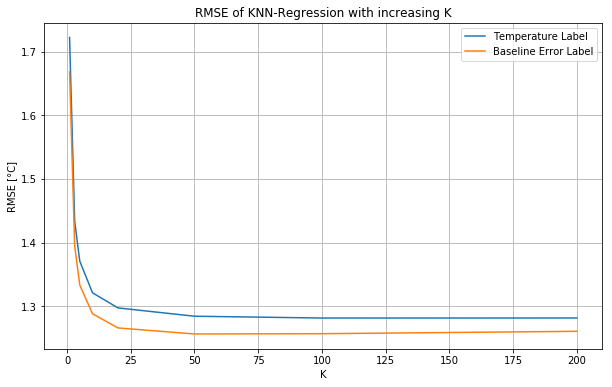

In [234]:
fig, ax = plt.subplots(figsize=(10,6))
k_temp, rmse_temp = list(zip(*rmse_result_temp_prediction))
k_error, rmse_error = list(zip(*rmse_result))
ax.plot(k_temp[:-2], rmse_temp[:-2])
ax.plot(k_error[:-3], rmse_error[:-3])
ax.set_xlabel('K')
ax.set_ylabel('RMSE [°C]')
plt.legend(['Temperature Label', 'Baseline Error Label'])
plt.title('RMSE of KNN-Regression with increasing K')
plt.grid()
plt.show()

# Backup

## Results with Shapley values of temperature prediction with bucket size 2°C

In [32]:
shapley_results_temp_2_0 = np.load('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_final/knn_results_20_percent_bucket_2_0_k_50.npz')['arr_0']

In [33]:
complete_shapley_sum_2_0 = None
for result in shapley_results_temp_2_0:
    try:
        complete_shapley_sum_2_0 += result[1]
    except:
        print('First')
        complete_shapley_sum_2_0 = result[1]

First


In [34]:
complete_shapley_sum_2_0

array([ 0.01594537, -0.03228186,  0.00668638, ...,  0.01448624,
        0.0700158 ,  0.0013124 ])

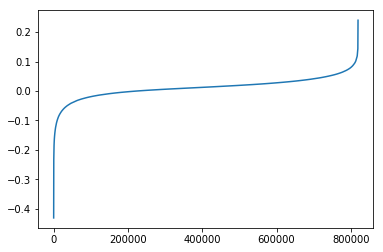

In [35]:
ordered_shapley_indices_2_0 = np.argsort(complete_shapley_sum_2_0)
plt.plot(np.arange(len(ordered_shapley_indices_2_0)), complete_shapley_sum_2_0[ordered_shapley_indices_2_0])
plt.show()

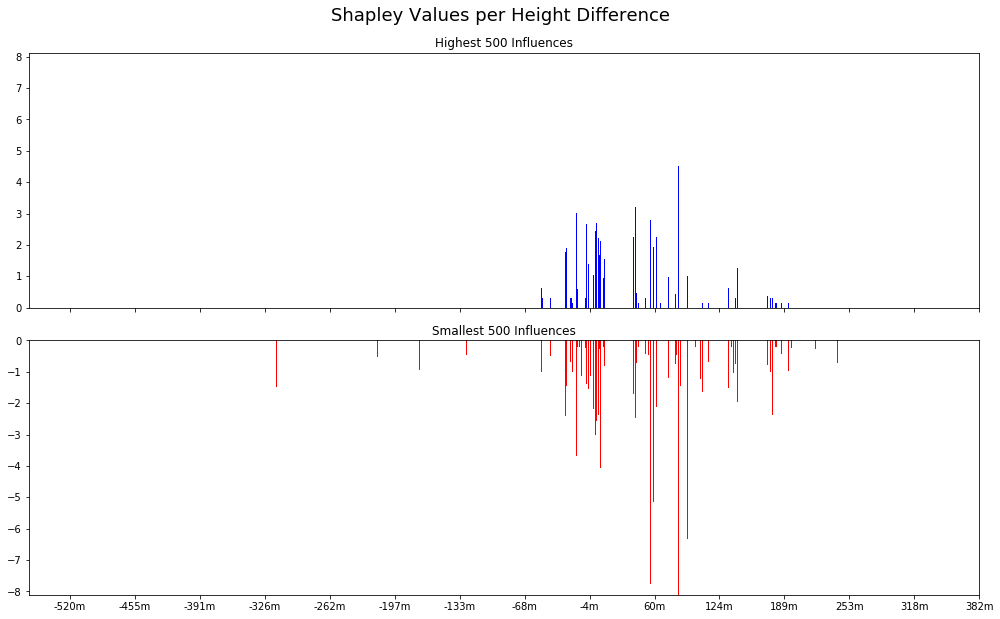

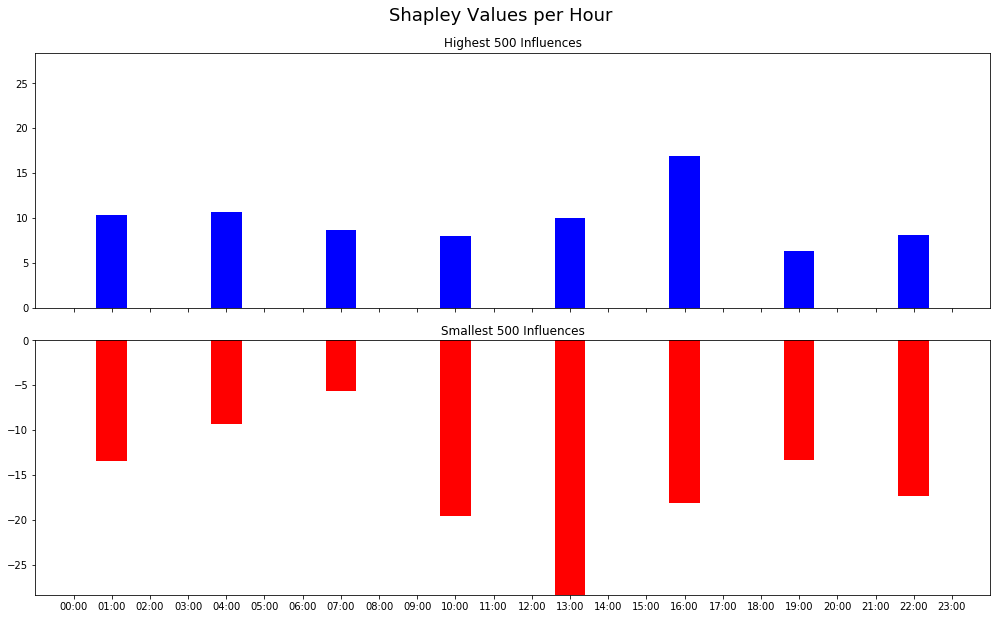

{3, 4, 5, 6, 7, 8, 9, 10}
[ 0.          0.          0.15316708  2.18337432 15.92913977 35.19661196
  9.18345772 11.1397708   4.92850609  0.30325911  0.          0.        ]


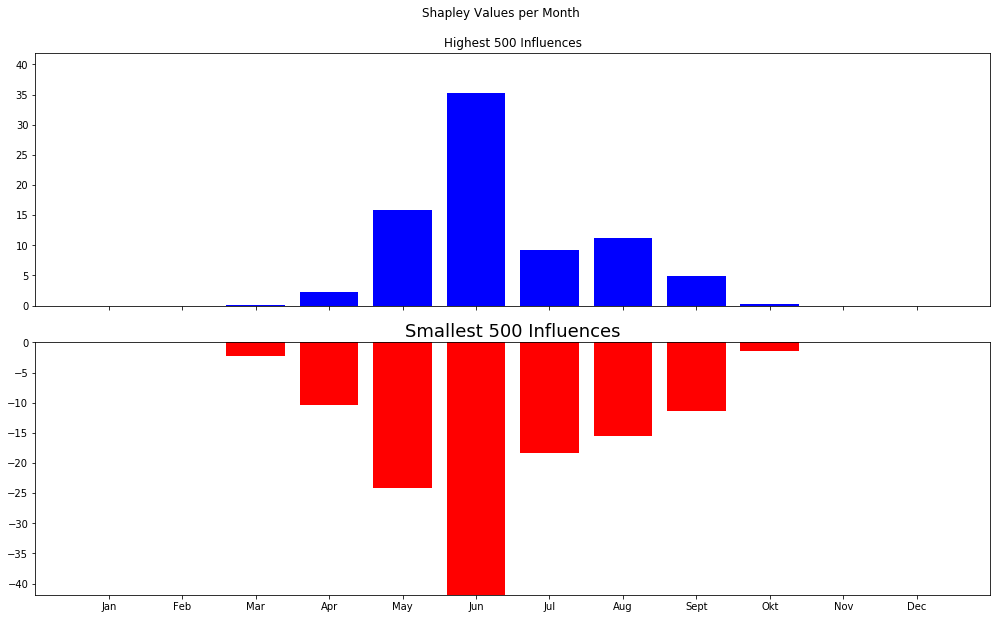

In [36]:
plotBestWorstShapleyResultsAllData(500, complete_shapley_sum_2_0)

### Plot shapley values against label

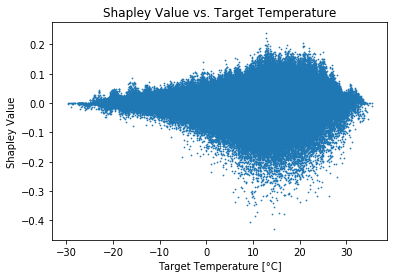

In [37]:
plt.scatter(Y_train_temp,complete_shapley_sum_2_0,s=0.5)
plt.xlabel('Target Temperature [°C]')
plt.ylabel('Shapley Value')
plt.title('Shapley Value vs. Target Temperature')
plt.show()

In [243]:
station_index_dict = {}
for s_idx, s in enumerate(prediction_error.station.data):
    station_index_dict[s] = s_idx

init_index_dict = {}
for i_idx, i in enumerate(prediction_error.init.data):
    init_index_dict[i] = i_idx

train_data_set_init_station = train_data_set[['Init', 'Station']]
model_error = prediction_error.sel(data = 'difference')
baseline_error = prediction_error.sel(data = 'cosmo') - prediction_error.sel(data = 'target')
model_train_error = np.zeros(train_data_set_init_station.shape[0])
baseline_train_error = np.zeros(train_data_set_init_station.shape[0])
for idx in train_data_set_init_station.index:
    init, station = train_data_set_init_station.iloc[idx]
    model_train_error[idx] = model_error.isel(init = init_index_dict[init], station = station_index_dict[station])
    baseline_train_error[idx] = baseline_error.isel(init = init_index_dict[init], station = station_index_dict[station])
    if (idx + 1) % 1000 == 0:
        print("Samples processed: %s" % idx)

Samples processed: 999
Samples processed: 1999
Samples processed: 2999
Samples processed: 3999
Samples processed: 4999
Samples processed: 5999
Samples processed: 6999
Samples processed: 7999
Samples processed: 8999
Samples processed: 9999
Samples processed: 10999
Samples processed: 11999
Samples processed: 12999
Samples processed: 13999
Samples processed: 14999
Samples processed: 15999
Samples processed: 16999
Samples processed: 17999
Samples processed: 18999
Samples processed: 19999
Samples processed: 20999
Samples processed: 21999
Samples processed: 22999
Samples processed: 23999
Samples processed: 24999
Samples processed: 25999
Samples processed: 26999
Samples processed: 27999
Samples processed: 28999
Samples processed: 29999
Samples processed: 30999
Samples processed: 31999
Samples processed: 32999
Samples processed: 33999
Samples processed: 34999
Samples processed: 35999
Samples processed: 36999
Samples processed: 37999
Samples processed: 38999
Samples processed: 39999
Samples pro

Samples processed: 320999
Samples processed: 321999
Samples processed: 322999
Samples processed: 323999
Samples processed: 324999
Samples processed: 325999
Samples processed: 326999
Samples processed: 327999
Samples processed: 328999
Samples processed: 329999
Samples processed: 330999
Samples processed: 331999
Samples processed: 332999
Samples processed: 333999
Samples processed: 334999
Samples processed: 335999
Samples processed: 336999
Samples processed: 337999
Samples processed: 338999
Samples processed: 339999
Samples processed: 340999
Samples processed: 341999
Samples processed: 342999
Samples processed: 343999
Samples processed: 344999
Samples processed: 345999
Samples processed: 346999
Samples processed: 347999
Samples processed: 348999
Samples processed: 349999
Samples processed: 350999
Samples processed: 351999
Samples processed: 352999
Samples processed: 353999
Samples processed: 354999
Samples processed: 355999
Samples processed: 356999
Samples processed: 357999
Samples proc

Samples processed: 636999
Samples processed: 637999
Samples processed: 638999
Samples processed: 639999
Samples processed: 640999
Samples processed: 641999
Samples processed: 642999
Samples processed: 643999
Samples processed: 644999
Samples processed: 645999
Samples processed: 646999
Samples processed: 647999
Samples processed: 648999
Samples processed: 649999
Samples processed: 650999
Samples processed: 651999
Samples processed: 652999
Samples processed: 653999
Samples processed: 654999
Samples processed: 655999
Samples processed: 656999
Samples processed: 657999
Samples processed: 658999
Samples processed: 659999
Samples processed: 660999
Samples processed: 661999
Samples processed: 662999
Samples processed: 663999
Samples processed: 664999
Samples processed: 665999
Samples processed: 666999
Samples processed: 667999
Samples processed: 668999
Samples processed: 669999
Samples processed: 670999
Samples processed: 671999
Samples processed: 672999
Samples processed: 673999
Samples proc

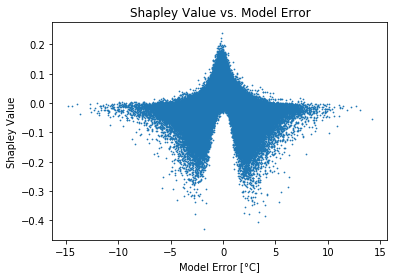

In [249]:
plt.scatter(model_train_error, complete_shapley_sum_2_0, s=0.5)
plt.xlabel('Model Error [°C]')
plt.ylabel('Shapley Value')
plt.title('Shapley Value vs. Model Error')
plt.show()

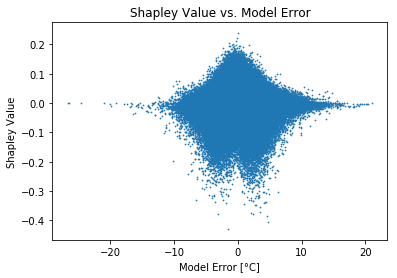

In [250]:
plt.scatter(baseline_train_error,complete_shapley_sum_2_0, s=0.5)
plt.xlabel('Model Error [°C]')
plt.ylabel('Shapley Value')
plt.title('Shapley Value vs. Model Error')
plt.show()

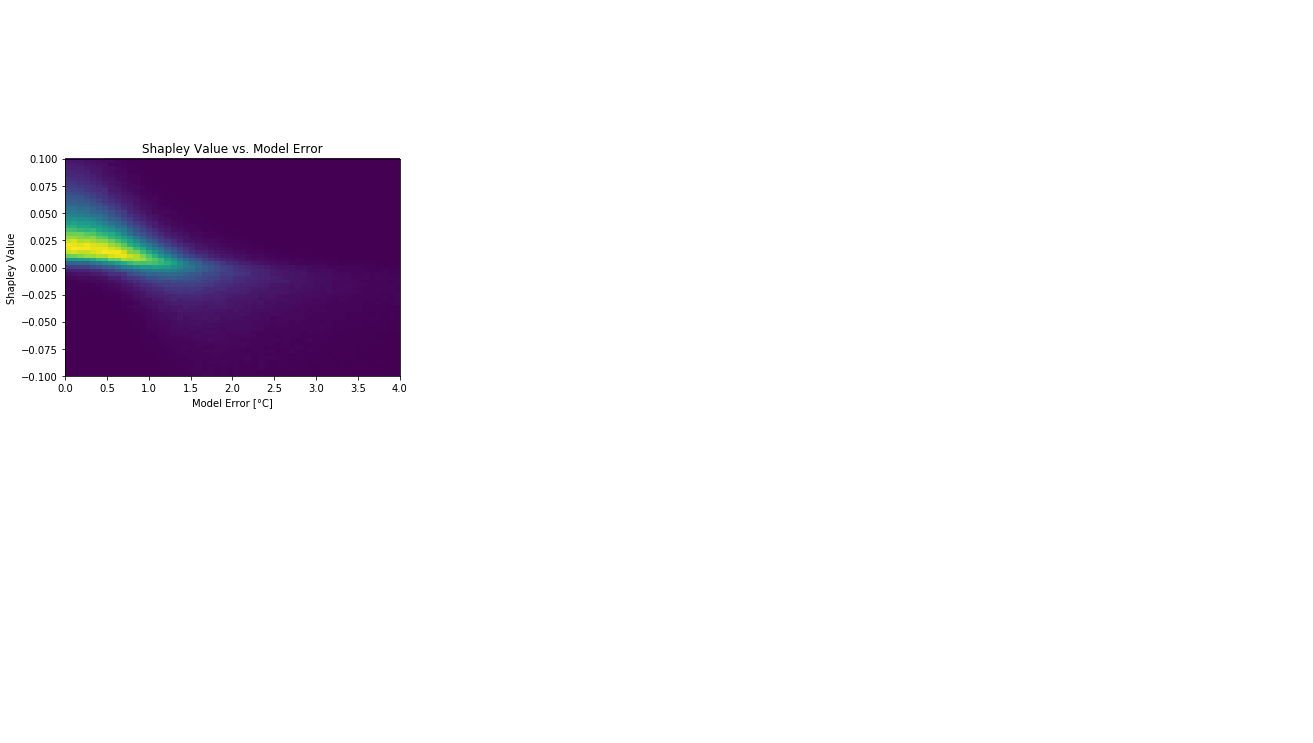

In [54]:
plt.hist2d(model_error,complete_shapley_sum_2_0, bins=200)
plt.xlim(0,4)
plt.ylim(-0.1, 0.1)
plt.xlabel('Model Error [°C]')
plt.ylabel('Shapley Value')
plt.title('Shapley Value vs. Model Error')
plt.show()

In [55]:
np.mean(complete_shapley_sum_2_0)

0.011803587945168038

In [56]:
np.mean(complete_shapley_sum_0_5)

0.006519117241513956

## Correlations between differnet errors

### Cosmo Error vs. Temperature Label

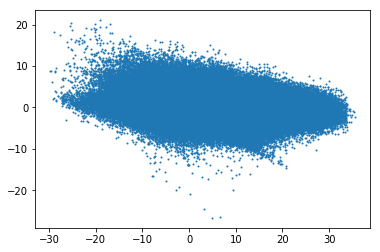

In [172]:
plt.scatter(temperature_prediction_label.data.flatten(), cosmo_error.data.flatten(), s=1)
plt.show()

### Model Error vs. Temperature Label

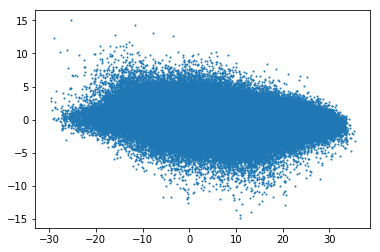

In [173]:
plt.scatter(temperature_prediction_label.data.flatten(), teperature_prediction_model_error.data.flatten(), s=1)
plt.show()

### Cosmo Error vs. Model Error

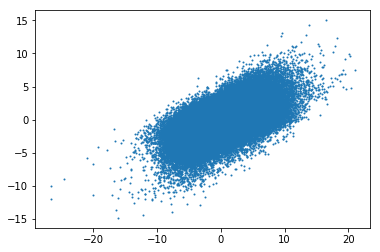

In [174]:
plt.scatter(cosmo_error.data.flatten(), teperature_prediction_model_error.data.flatten(), s=1)
plt.show()

### Error Label vs. Cosmo Error

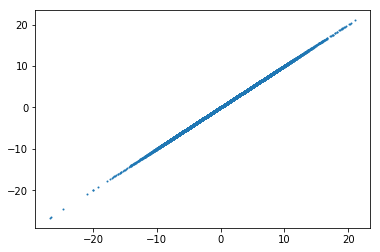

In [179]:
plt.scatter(error_prediction_label.data.flatten(), cosmo_error.data.flatten(), s=1)
plt.show()

### Error Label vs. Model  Error Prediction Temperature Error

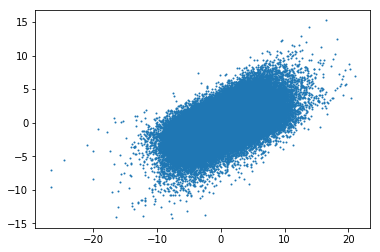

In [180]:
plt.scatter(error_prediction_label.data.flatten(), error_prediction_model_temperature_error.data.flatten(), s=1)
plt.show()

### Temperature Label vs. Cosmo Error

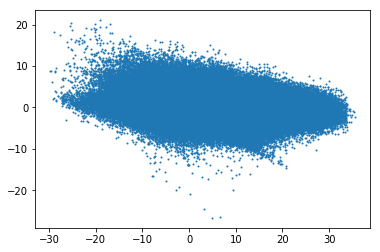

In [181]:
plt.scatter(error_prediction_temperature_label.data.flatten(), cosmo_error.data.flatten(), s=1)
plt.show()

### Temperature Label vs. Model Error Prediction Temp. Error

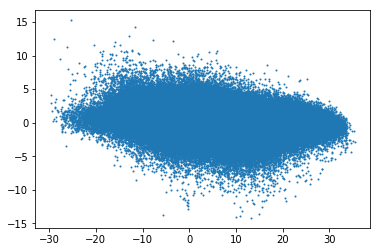

In [182]:
plt.scatter(error_prediction_temperature_label.data.flatten(), error_prediction_model_temperature_error.data.flatten(), s=1)
plt.show()

### Cosmo Error vs. Model Error Prediction Error

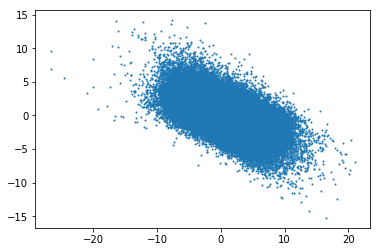

In [183]:
plt.scatter(cosmo_error.data.flatten(), error_prediction_model_error.data.flatten(), s=1)
plt.show()

### Model Error vs. Tempeartur Label

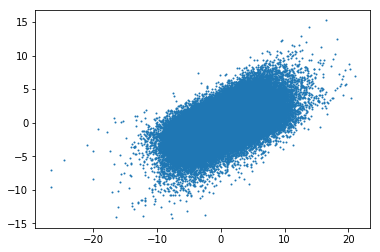

In [158]:
plt.scatter(baseline_error.data.flatten(), error_label_prediction_error.data.flatten(), s=1)
plt.show()

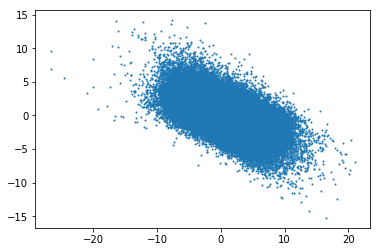

In [159]:
plt.scatter(baseline_error.data.flatten(), prediction_error_error_label.sel(data = 'difference').data.flatten(), s=1)
plt.show()

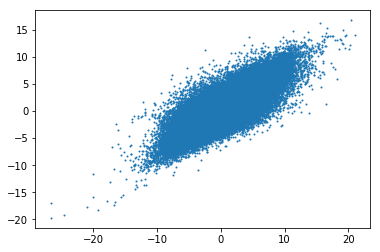

In [160]:
plt.scatter(baseline_error.data.flatten(), prediction_error_error_label.sel(data = 'prediction').data.flatten(), s=1)
plt.show()